In [131]:
import numpy as np
import pandas as pd

Import the data sets: prosecutor, sentencing, flagged cases.

In [ ]:
pros = pd.read_csv('Emory-Prosecutor Data-02-23-2023_name_rem.csv')
sent = pd.read_csv('Emory-Sentencing Information-02-27-2023_name_rem.csv')
flagged = pd.read_csv('/Users/clairefenton/Downloads/2023-03-02_name_removed/Flagged Cases-02-23-2023_name_rem.csv')

Define all the policy-eligible statutes based on the document provided by the District Attorney's Office. Each list contains statutes that apply to a different section fo the policy. Combine all the eligible statutes across the different policy sections.

In [133]:
vgsca = ['16-13-30a', '16-13-30b', '16-13-30l2', '16-13-30i1', '16-13-30i2', '16-13-24', '16-13-26', '16-13-1c', '16-13-1b', '16-13-3', '16-13-21', '16-13-30.1', '16-13-30.2']
forgery = ['16-9-1a', '16-9-1b', '16-9-1c', '16-9-1d', '16-9-1e']
fraud = ['16-9-121a1', '16-9-121a2', '16-9-121a3', '16-9-121a4', '16-9-121a5', '16-9-33', '16-9-31']
theft = ['16-18-4']
burglary = ['16-7-1b', '16-7-1c', '16-8-18']
eligible = vgsca + forgery + fraud + theft + burglary

Merge the prosecutor and sentencing data sets using a left join so that case, attorney and defendant demographic information is all in one place.

In [134]:
sent['Matching_ID'] = sent.CaseNbr + sent.PartyID.astype(str)
pros['Matching_ID'] = pros.CaseNumber + pros.UniquePersonID.astype(str)

Merged = sent.merge(pros, on='Matching_ID', how='left')
Merged.to_csv("test.csv")

col_values = []
for col in Merged:
    col_values.append(Merged[col].unique())

col_names = []
for col in Merged.columns:
    col_names.append(col)

uniqe_value = {col_names[i]: col_values[i] for i in range(len(col_names))}

In [ ]:
Merged.Degree.value_counts()

There are 389,119 felony charges in the joined data set.

Define a function for standardizing the format of the statutes to account for human error. Removes all whitespaces, parentheses, extraneous dashes and sets all the letters to lower case.

In [136]:
def formatStatute(statute):
    statute = statute.lower()
    statute = statute.replace('(', '').replace(')', '').replace('s', '').replace(' ', '')
    if statute.count('-') >= 3:
        index = -1
        while statute.count('-') > 2:
            if statute[index] == '-':
                statute = statute[:index] + statute[(index + 1):]
            else:
                index = index - 1
    return statute 

Clean all the statutes in the merged data set.

In [137]:
messyStatutes = Merged.Statute.copy()
for i in range(0, len(messyStatutes)):
    messy = messyStatutes[i]
    if type(messyStatutes[i]) != float:
        messyStatutes[i] = formatStatute(messy)

Add the cleaned statutes back into the merged data set as a separate column, `cleanedStatute`.

In [138]:
Merged['cleanedStatute'] = messyStatutes

In [139]:
print('Number of cases: ', len(flagged[flagged['CaseFlagWord'] == 'CBL']['ControlNum'].unique()))
print('Number of flagged cases: ', len(flagged[flagged['CaseFlagWord'] == 'CBL']))

Number of cases:  1993
Number of flagged cases:  2119


There are 1993 unique case numbers in the flagged data set and 2119 observations flagged with the CBL tag (policy eligible) in the merged data set.

Merge the `Merged` data set with the flagged data set, which contains 1,154,945 observations.

In [ ]:
result = pd.merge(flagged, Merged, left_on = 'ControlNum', right_on = 'CaseNumber', how = 'right')
result = result[(result['CaseNbr'].str.contains("CR")) | (result['CaseNbr'].str.contains("D"))]

Look for where and how frequently null values occur.

In [ ]:
result.info()

In [142]:
len(result[(result['Degree'] == 'Felony') | (result['Degree'] == 'Serious Felony')])/len(result['Degree'])

0.6635574848340517

In the final data set, 66.36% of the charges are felonies.

In [ ]:
markedCBL = result[result['CaseFlagWord'] == 'CBL'].cleanedStatute.unique()
print('Number of different statutes for flagged cases: ', len(markedCBL))
print('Number of eligible statutes according to DA\'s Office: ', len(eligible))

There are 233 different statutes represented in the cases flagged as CBL, which is far more than the 29 included in the official statute list from the DA's Office.

Extract only the cases which are flagged as "CBL" from the flagged data set.

In [144]:
cbl = flagged[flagged['CaseFlagWord'] == 'CBL']

In [ ]:
unaccountedFor = []
for case in list(cbl['ControlNum']):
    if case not in list(Merged['CaseNumber']):
        unaccountedFor.append(case)
len(unaccountedFor)

There are 357 case numbers marked as CBL that do not appear in the prosecuting and sentencing data set. All these charges can not be included in the final analysis since there is no information regarding the statutes, temporal markers, disposition information or defendant demographics for any of them. 

Specify the charge dispositions which indicate the policy was applied, a list of which the DA's Office provided. 

In [146]:
statutes = eligible
dispositions = ['Pre Trial Diversion - Restrict', 'Dismissed - Converted', 'Not Presented to Grand Jury - Restrict - Converted', 'Nolle Prosse - Converted', 'Dismissed - Completed Pretrial Diversion', 'Dismissed', 'Dismissed - Restrict', 'Dismissed - Restricted', 'Nolle Prosse - Restrict', 'Not Presented to Grand Jury - Restrict']

Specify serious felonies as indicated in a list which the DA's Office provided. 

In [147]:
svf = ['16-10-32a3', '16-10-70b', '16-11-1', '16-11-133b', '16-11-160', '16-11-1602bi', '16-11-160a2', '16-11-160a1', '16-11-160c', '16-11-1a', '16-13-30b', '16-13-2012', '16-13-31b', '16-13-31d', '16-13-31f', '16-13-31.1a', '16-5-1a', '16-5-1c', '16-5-1d', '16-5-24a', '16-5-24c1', '16-5-24g', '16-5-40a', '16-5-44', '16-5-44.1(b)(1)', '16-5-44.1(b)(2)', '16-5-46(c)', '16-5-72(a)', '16-5-80(b)', '16-6-1(a)', '16-6-2(a)(2)', '16-6-22', '16-6-22.2(b)', '16-6-22a', '16-6-3(a)', '16-6-4(c)', '16-6-5(a)', '16-7-5(b)', '16-7-88(a)', '16-7-88(b)', '16-8-41(a)', '16-8-41(c)(1)', '17-10-16a', '17-10-6.1b1-2', '17-10-7', '17-10-7c']
for i in range(0, len(svf)):
    messy = svf[i]
    svf[i] = formatStatute(messy)

Collect a bank of all the eligible statutes — those flagged in a CBL case and misdemeanors — in a list.

In [148]:
eligibleDis = list(result[(result['CaseFlagWord'] == 'CBL') | (result['Degree'] == 'Misdemeanor')].cleanedStatute.unique())

Collect a bank of the reamining, ineligible statutes in a separate list.

In [149]:
noneligibleDis = []

for i in result.cleanedStatute.unique():
    if i not in eligibleDis:
        noneligibleDis.append(i)

Examine each case brought against a person and collect all the charges associated with it for each defendant. If the defendant has no ineligible charges brought against them, they are added to a dictionary containing all the case-defendant pairings that are eligible for the policy.

In [150]:
defendantsDiscretion = {}

groupedPersons = result.groupby('Matching_ID')

for group in groupedPersons:
    crimes = list(group[1].cleanedStatute.unique())
    if bool(set(crimes) & set(noneligibleDis)):
        defendantsDiscretion[group[1].Matching_ID.unique()[0]] = False
    else:
       defendantsDiscretion[group[1].Matching_ID.unique()[0]] = True 


In [151]:
result = result.reset_index()

Determine eligibility based on following critieria for a defendant's charges:
1. Misdemeanor
2. Flagged as CBL
3. All appear under cases flagged as CBL

Determine if the policy was applied based on the following criteria:
1. Eligible according to above criteria
2. Disposition in list provided by DA's Office

In [152]:
disFlag = []
disApplied = []
for i in range(0, len(result)):
    value = defendantsDiscretion[result['Matching_ID'][i]]
    disFlag.append(value)
    if ((value == True) & (result['ChargeDisposition'][i] in dispositions)):
        disApplied.append(True)
    else:
        disApplied.append(False)

Append the eligibility and applied information to the data set as the `CaseFlagDiscretion` and `PolicyAppliedDiscretion` columns.

In [153]:
result['CaseFlagDiscretion'] = disFlag
result['PolicyAppliedDiscretion'] = disApplied

In [ ]:
result[(result['CaseFlagDiscretion'] == True) & (result['CaseFlagWord'] == 'CBL') & (result['PolicyAppliedDiscretion'] == False)]

There are 859 charges which were eligible and flagged as CBL but not dismissed under the policy.

In [155]:
print("Eligible Charges: ", len(result[result['CaseFlagDiscretion'] == True]))
print("Applied Charges: ", len(result[result['PolicyAppliedDiscretion'] == True]))

Eligible Charges:  319623
Applied Charges:  49113


Including misdemeanors, which make up the majority of charges, there are 319,623 charges eligible for dismissal under the policy and 49,113 had the policy applied. Since misdemeanors were already up for dismissal before the policy implementation, examining the non-violent felonies only is important for seeing how the policy is put into practice.

In [156]:
onlyFel = result[(result['Degree'] != 'Misdemeanor') & (result['CaseFlagDiscretion'] == True)]
print("Eligible Charges: ", sum(onlyFel['CaseFlagDiscretion']))
print("Applied Charges: ", len(onlyFel[onlyFel['PolicyAppliedDiscretion'] == True]))

Eligible Charges:  199386
Applied Charges:  30608


Excluding misdemeanors, there are 199,386 charges eligible for dismissal under the policy and 30,608 had the policy applied. However, most of the eligible charges fall outside the data range of the policy. 

In [157]:
import datetime
import math

Format the `DateFiled`, `CaseOriginDate` and `DispositionDate` columns as `datetime` objects and re-append them to the data frame as `FormattedDateFiled`, `FormattedCaseOriginDate` and `FormattedDispositionDate`.

In [158]:
FormattedDispositionDate = pd.to_datetime(result['DispositionDate'])
FormattedCaseOriginDate = pd.to_datetime(result['CaseOriginDate'])
FormattedDateFiled = pd.to_datetime(result['DateFiled'])

In [159]:
result['FormattedDispositionDate'] = FormattedDispositionDate
result['FormattedCaseOriginDate'] = FormattedCaseOriginDate
result['FormattedDateFiled'] = FormattedDateFiled

Sort the data set by `FormattedCaseDate`, from earliest to latest.

In [160]:
result = result.sort_values(by='FormattedCaseOriginDate')
result = result.reset_index()

Not all the observations in the data have a `CaseOriginDate` value, making it difficult to be certain about whether or not a charge occurred berfore, after or concurrent with a defendant's first arrest. Therefore, extract a subset of the data containing only observations for which `CaseOriginDate` is not null when examining recidivism data that contains 67,839 individuals, 31.72% of those in the entire data set.

In [161]:
recidAvailable = result[pd.notnull(result['CaseOriginDate'])]
print('Number of individuals for which recidivism can be analyzed: ', len(recidAvailable.PartyID.unique()))
print('Percentage of individuals for which recidivism can be analyzed: ', len(recidAvailable.PartyID.unique())/len(result.PartyID.unique()))

Number of individuals for which recidivism can be analyzed:  67839
Percentage of individuals for which recidivism can be analyzed:  0.31722554488873095


Create recidivism variable that identifies defendants who have previously appeared in the data set according to the `CaseOriginDate`.

Collect all the defendants' `PartyID` values. Loop through every observation for which recidivism information can be determined. If the defendant's `PartyID` has not be seen previously, the observation is the defendant's first (or only) arrest. Otherwise, the defendant is a recidivist and has had an earlier arrest.

In [162]:
allParties = list(recidAvailable.PartyID.unique())

In [163]:
visitedCases = []
earlierArrest = []

for i in range(0, len(recidAvailable)):
    if recidAvailable['PartyID'][i] in allParties:
        visitedCases.append(recidAvailable['Matching_ID'][i])
        delete = allParties.index(recidAvailable['PartyID'][i])
        del allParties[delete]
        earlierArrest.append(False)
    elif recidAvailable['Matching_ID'][i] in visitedCases:
        earlierArrest.append(False)
    else:
        earlierArrest.append(True)

Add the recidivism information to the subset of the data frame containing only non-null `CaseOriginDate` values as an `EarlierArrest` column.

In [ ]:
recidAvailable['EarlierArrest'] = earlierArrest

In [ ]:
check = result[['CaseNbr', 'PartyID', 'ChargeID', 'Degree', 'cleanedStatute', 'CaseFlagWord', 'CaseFlagDiscretion', 'CaseOriginDate']]
check[(check['CaseFlagDiscretion'] == True) & (check['Degree'] != 'Misdemeanor') & (check['CaseFlagWord'] == 'CBL')]

There are 2,823 non-misdemeanor charges with perfect alignment: we marked as eligible according to `CaseFlagDiscretion` and they are flagged as CBL in `CaseFlagWord`.

In [166]:
allEligibleFel = check[((check['CaseFlagDiscretion'] == True) | (check['CaseFlagWord'] == 'CBL')) & (check['Degree'] != 'Misdemeanor')]
print(len(allEligibleFel))

199386


There are 199,386 eligible non-misdemeanor charges across the entire data set.

In [167]:
flaggedTrue = allEligibleFel[allEligibleFel['CaseFlagDiscretion'] == True]
flaggedTrue.CaseFlagWord.value_counts()

CBL        2823
DCAP       1834
DCAPREF     272
Name: CaseFlagWord, dtype: int64

There are only 2,823 total CBL flags appearing in all the eligiblee non-misdemeanor charges, and only 4,929 total observations containing a `CaseFlagWord` value. Most eligible cases do not have any `CaseFlagWord` data.

In [168]:
cblEligible = recidAvailable[['CaseNbr', 'PartyID', 'ChargeID', 'Degree', 'cleanedStatute', 'CaseFlagWord', 'CaseFlagDiscretion', 'PolicyAppliedDiscretion', 'CaseOriginDate']]
cblEligible = cblEligible[cblEligible['CaseFlagWord'] == 'CBL']

There are many statutes corresponding with CBL cases that are not included in the list of statutes provided by the DA's Office. Such instances might be examples of prosecutors using discretion and dismissing ineligible cases in the spirit of the policy, or could result from unobservable factors about the defendant, such as their prior arrest record outside of DeKalb County. These statutes could also correspond to misdemeanor offenses, which would not appear on the list provided by the DA's Office but would still be policy eligible.

The `cblEligible` subset, which contains all CBL cases for which recidivism can be analyzed, is what must be used to calculate the policy applied rate.

In [169]:
print("CBL eligible charges: ", len(cblEligible[cblEligible['CaseFlagDiscretion'] == True]))
print("Applied charges: ", len(cblEligible[cblEligible['PolicyAppliedDiscretion'] == True]))
print("Percentage of CBL charges deemed applied: ", len(cblEligible[cblEligible['PolicyAppliedDiscretion'] == True])/len(cblEligible))

CBL eligible charges:  4252
Applied charges:  3394
Percentage of CBL charges deemed applied:  0.7982126058325494


Three are 4,252 CBL eligible charges and 3,394 had the policy applied, a 79.82% dismissal rate.

In [170]:
print("Percentage of CBL charges which are not misdemeanors: ", len(cblEligible[cblEligible['Degree'] != 'Misdemeanor'])/len(cblEligible))
print("Percentage of applied CBL charges which are not misdemeanors: ", len(cblEligible[(cblEligible['Degree'] != 'Misdemeanor') & (cblEligible['CaseFlagDiscretion'] == True) & (cblEligible['PolicyAppliedDiscretion'] == True)])/len(cblEligible))

Percentage of CBL charges which are not misdemeanors:  0.6632173095014111
Percentage of applied CBL charges which are not misdemeanors:  0.5195202257761053


In [171]:
len(recidAvailable[recidAvailable['EarlierArrest'] == True].PartyID.unique())/len(recidAvailable.PartyID.unique())

0.15144680788337092

Around 15% of defendants for which recidivism within DeKalb County can be analyzed are recidivists. 

Import `datetime` and  `matplotlib` packages for creating charts.

In [172]:
from matplotlib import pyplot

Separate the eligible and ineligible populations according to `CaseFlagDiscretion` and only include cases pending in the DA's Office after March 13, 2020.

In [173]:
eligibleByDiscretion = recidAvailable[(recidAvailable['CaseFlagDiscretion'] == True) & (recidAvailable['FormattedDispositionDate'] > datetime.datetime(2020, 3, 13))]
ineligibleByDiscretion = recidAvailable[(recidAvailable['CaseFlagDiscretion'] == False) & (recidAvailable['FormattedDispositionDate'] > datetime.datetime(2020, 3, 13))]

For all charges appearing after March 13, 2020, determine whether the given case is the first for the defendant since the policy implementation or whether they already had an arrest prior to their current one. 

In [174]:
allParties = list(eligibleByDiscretion['PartyID'].unique())
eligibleByDiscretion = eligibleByDiscretion.sort_values(by='FormattedDispositionDate')
del eligibleByDiscretion['level_0']
eligibleByDiscretion = eligibleByDiscretion.reset_index()
dismissedDefendants = {}

subset = eligibleByDiscretion[['PartyID', 'Matching_ID', 'FormattedDispositionDate', 'FormattedCaseOriginDate']]
for i in range(0, len(subset)):
    if subset.loc[i][0] not in dismissedDefendants:
        dismissedDefendants[subset.loc[i][0]] = [subset.loc[i][2]]

multArrests = []
for i in range(0, len(recidAvailable)):
    if recidAvailable['PartyID'][i] in dismissedDefendants.keys():
        if recidAvailable['FormattedCaseOriginDate'][i] > dismissedDefendants[recidAvailable['PartyID'][i]][0]:
            multArrests.append(True)
        else:
            multArrests.append(False)
    else:
        multArrests.append(False)

Append `ArrestSincePolDisposition` column to the data set, which contains a boolean value indicating whether or not the defendant associated with a particular charge has had a prior arrest since the policy implementation.

In [ ]:
recidAvailable['ArrestSincePolDisposition'] = multArrests

In [176]:
eligibleByDiscretion = recidAvailable[(recidAvailable['CaseFlagDiscretion'] == True) & (recidAvailable['FormattedDispositionDate'] > datetime.datetime(2020, 3, 13))]
ineligibleByDiscretion = recidAvailable[(recidAvailable['CaseFlagDiscretion'] == False) & (recidAvailable['FormattedDispositionDate'] > datetime.datetime(2020, 3, 13))]

Since the novelty of the policy concerns only non-violent felonies, for the purpose of our analysis we want to exclude all defendants from the policy eligible group who have only committed misdemeanor crimes. 

In [177]:
test = pd.DataFrame(eligibleByDiscretion.groupby('Matching_ID')['Degree'].apply(lambda x: list(np.unique(x)))).reset_index()
onlyMisdemeanors = []
for i in range(len(test)):
    if test.Degree[i] == ['Misdemeanor']:
        onlyMisdemeanors.append(test.Matching_ID[i])
print(len(onlyMisdemeanors))

856


Separate the eligible, policy applied group from the eligible, policy not applied group. The policy applied group includes all CBL charges for which `PolicyAppliedDiscretion` is true and the case does not contain only misdemeanors. The policy not applied group includes all other charges and excludes all cases with only misdemeanors. 

In [178]:
eligibleByDiscretionApplied = eligibleByDiscretion[((eligibleByDiscretion['CaseFlagWord'] == 'CBL') & (eligibleByDiscretion['PolicyAppliedDiscretion'] == True)) & (-eligibleByDiscretion['Matching_ID'].isin(onlyMisdemeanors))]
noDup = eligibleByDiscretionApplied.Matching_ID.unique()
eligibleByDiscretionNotApplied = eligibleByDiscretion[(-eligibleByDiscretion['Matching_ID'].isin(noDup)) & (-eligibleByDiscretion['Matching_ID'].isin(onlyMisdemeanors))]

In [179]:
len(eligibleByDiscretionApplied.PartyID.unique()) + len(eligibleByDiscretionNotApplied.PartyID.unique())

6452

In [180]:
print(len(eligibleByDiscretionApplied) + len(eligibleByDiscretionNotApplied))

17775


There are 6,452 policy eligible defendants spanning 17,775 charges up for analysis.

Isolate the recidivist charges since the policy implementation for applied and not applied groups.

In [181]:
appliedIndividuals = eligibleByDiscretionApplied.PartyID.unique()
appliedRecidivistsCharges = recidAvailable[(recidAvailable['PartyID'].isin(appliedIndividuals)) & (recidAvailable['ArrestSincePolDisposition'] == True)]
numAppliedRecid = len(appliedRecidivistsCharges.PartyID.unique())
print(len(appliedIndividuals), numAppliedRecid)
print(numAppliedRecid/len(appliedIndividuals))

1416 46
0.03248587570621469


The applied group contains 46 recidivists from a population of 1,416, a 3.25% recidivism rate.

In [182]:
notAppliedIndividuals = eligibleByDiscretionNotApplied.PartyID.unique()
notAppliedRecidivistsCharges = recidAvailable[(recidAvailable['PartyID'].isin(notAppliedIndividuals)) & (recidAvailable['ArrestSincePolDisposition'] == True)]
numNotAppliedRecid = len(notAppliedRecidivistsCharges.PartyID.unique())
print(len(notAppliedIndividuals), numNotAppliedRecid)
print(numNotAppliedRecid/len(notAppliedIndividuals))

5036 212
0.04209690230341541


The not applied group contains 212 recidivists from a population of 5,036, a 4.21% recidivism rate. It seems as if the recidivism rate for the policy not applied group is higher, but is the difference statistically significant?

Perform a two sample Z-test for proportions to determine whether the two recidivism rates are statistically significantly different. The null hypothesis is that the two rates are the same. We are assuming that the two populations are normal, the two samples are randomly sampled and the two proportions are independent. 

phat1 = recidivism rate for policy applied
phat2 = recidivism rate for policy not applied
n1 = population size of policy applied
n2 = population size of policy not applied
k1 = number of recidvists in policy applied
k2 = number of recidivists in policy not applied
phat = mean rate of populations

In [183]:
phat1 = numAppliedRecid/len(appliedIndividuals)
phat2 = numNotAppliedRecid/len(notAppliedIndividuals)
n1 = len(appliedIndividuals)
n2 = len(notAppliedIndividuals)
k1 = numAppliedRecid
k2 = numNotAppliedRecid
phat = (k1 + k2)/(n1 + n2)

numer = phat1-phat2
denom = np.sqrt((phat * (1-phat)) * ((1/n1) + (1/n2)))

z = numer/denom
print(z)

-1.6307823122224447


At the 95% confidence threshold, |z| < 1.96, meaning the difference in recidivism rates is not yet statistically significant. However, our data pool is fairly small, so we must determine how much longer the DA's Office must collect data for significance to reveal itself if it it exists.

We are assuming the recivisim rates and the growth rates of n1 and n2 remain constant over time. Our date range spans March 13, 2020 to the latest avaialble case origin date present in the data set, Feb. 27, 2023. 

In [184]:
postPol = result[(result['FormattedCaseOriginDate'] > datetime.datetime(2020, 3, 13)) & (result['CaseFlagWord'] == 'CBL')]
numDays = datetime.datetime(2023, 2, 27) - list(postPol.FormattedCaseOriginDate)[0]
n1_rate = n1/numDays.days
n2_rate = n2/numDays.days
print(n1_rate, n2_rate)

1.3111111111111111 4.662962962962963


The policy applied group is growing at a rate of 1.31 people per day and the not applied group is growing at a rate of 4.67 people per day.

In [185]:
proj_n1 = (1078 + 223) * n1_rate
proj_n2 = (1078 + 223) * n2_rate
phat = (k1 + k2)/(proj_n1 + proj_n2)

numer = phat1-phat2
denom = np.sqrt((phat * (1-phat)) * ((1/proj_n1) + (1/proj_n2)))
z = numer/denom
print(z)

-1.9575753866439862


The DA's Office must collect data for another 223 days for |z| < 1.96 and, therefore, reveal significance if it is present. 

In [186]:
days_needed = 223
months_needed = days_needed/30
print('Months: ', months_needed)
years_needed = months_needed/12
print('Years: ', years_needed)

Months:  7.433333333333334
Years:  0.6194444444444445


The data collection period is 7.4 months, or 0.62 years.

VISUALS

Bar chart displaying the top 5 most frequent statutes for policy applied recidivists' charges on initial CBL dismissals.

In [187]:
appliedRecid = appliedRecidivistsCharges.PartyID.unique()
firstOffense = eligibleByDiscretionApplied[(eligibleByDiscretionApplied['ArrestSincePolDisposition'] == False) & (eligibleByDiscretionApplied['PartyID'].isin(appliedRecid))]

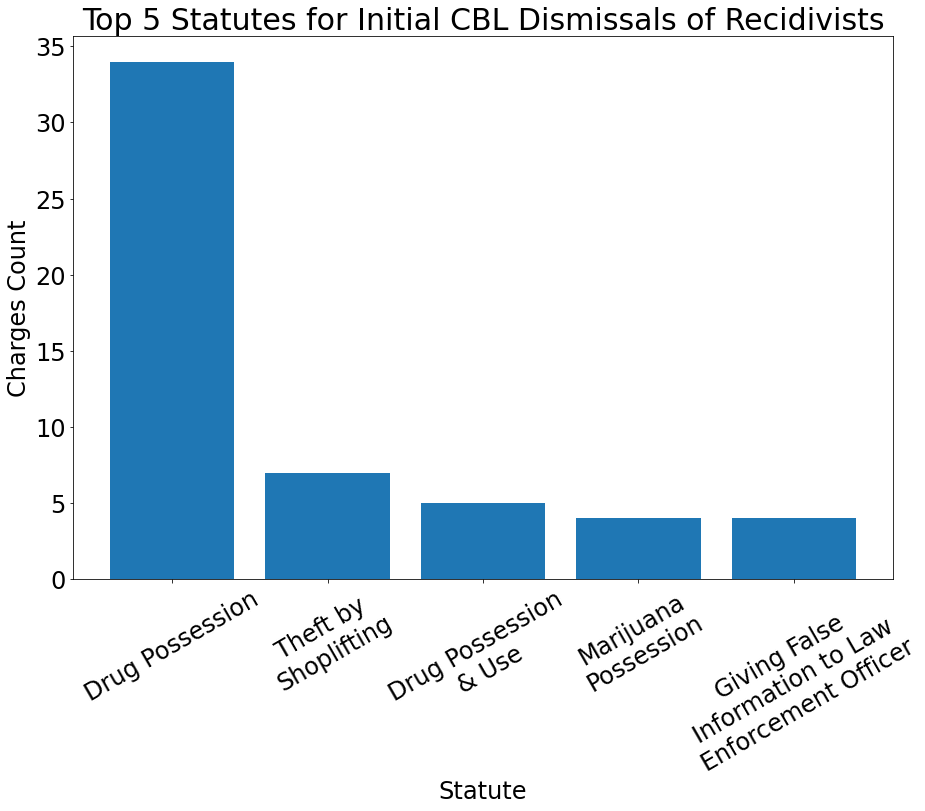

In [188]:
recidCount = firstOffense.cleanedStatute.value_counts().rename_axis('Statute').reset_index(name='Count')
labels = recidCount.Statute
counts = recidCount.Count

#names = list(labels)[:5]
names = ['Drug Possession', 'Theft by\nShoplifting', 'Drug Possession\n& Use', 'Marijuana\nPossession', 'Giving False\nInformation to Law\nEnforcement Officer']
values = list(counts)[:5]

pyplot.figure(figsize=(50, 10))
pyplot.subplot(131)
pyplot.bar(names, values)
pyplot.title('Top 5 Statutes for Initial CBL Dismissals of Recidivists', fontdict={'fontsize': 30})
pyplot.xlabel('Statute', fontsize=24)
pyplot.ylabel('Charges Count', fontsize=24)
pyplot.xticks(rotation=30, fontsize=24)
pyplot.yticks(fontsize=24)
       
pyplot.savefig('statute_initial_dismissal.png', dpi=300, bbox_inches='tight')

pyplot.show()

Pie chart displaying the charge severity for policy applied recidivists' charges on initial CBL dismissals.

([<matplotlib.patches.Wedge at 0x7ff334257790>,
 [Text(-1.0587007824634076, -0.29858441555340554, 'Felony'),
  Text(1.0587008104188933, 0.29858431643068367, 'Misdemeanor')],
 [Text(-0.5774731540709495, -0.1628642266654939, '58.7%'),
  Text(0.5774731693193963, 0.1628641725985547, '41.2%')])

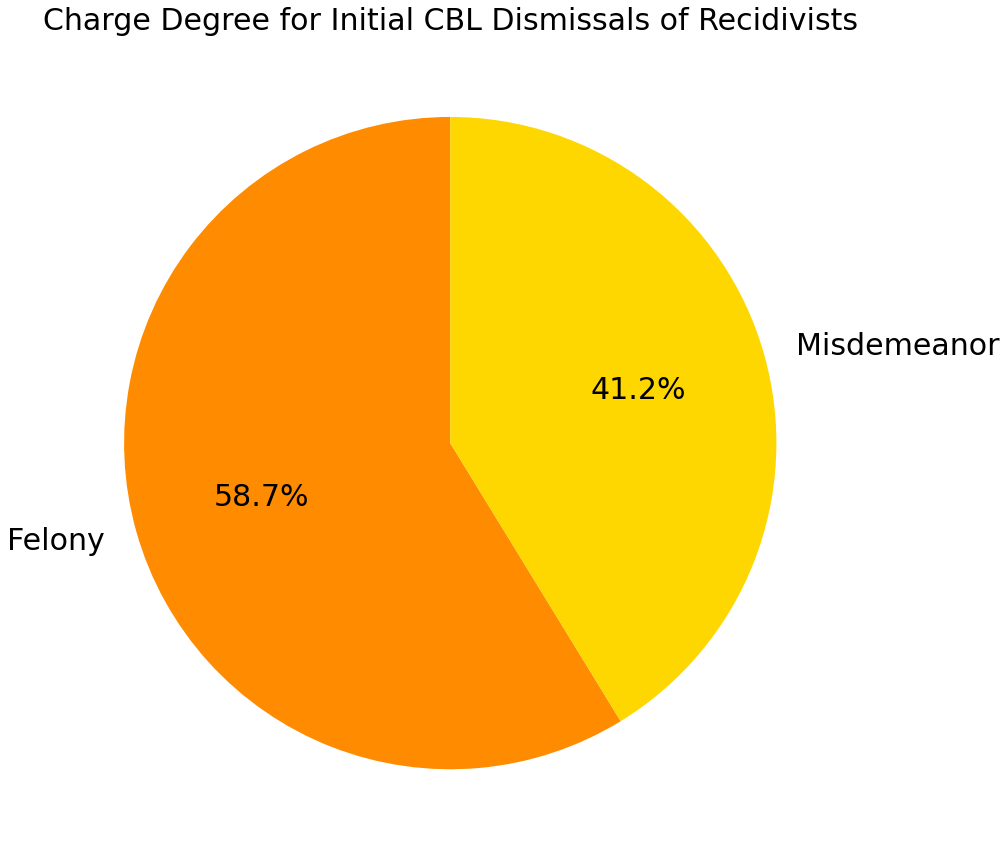

In [189]:
recidCount = firstOffense.Degree.value_counts().rename_axis('Degree').reset_index(name='Count')
labels = recidCount.Degree
counts = recidCount.Count

sizes = counts/sum(counts)
colors = ['darkorange', 'gold', 'red'] 

fig, ax = pyplot.subplots(figsize = (15, 15))
pyplot.title('Charge Degree for Initial CBL Dismissals of Recidivists', fontdict={'fontsize': 30})
pyplot.savefig('pie_initial.png')
ax.pie(sizes, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 30}, colors=colors, startangle= 90)

Bar chart displaying the top 5 most frequent statutes for policy applied recidivists' charges for subsequent arrests.

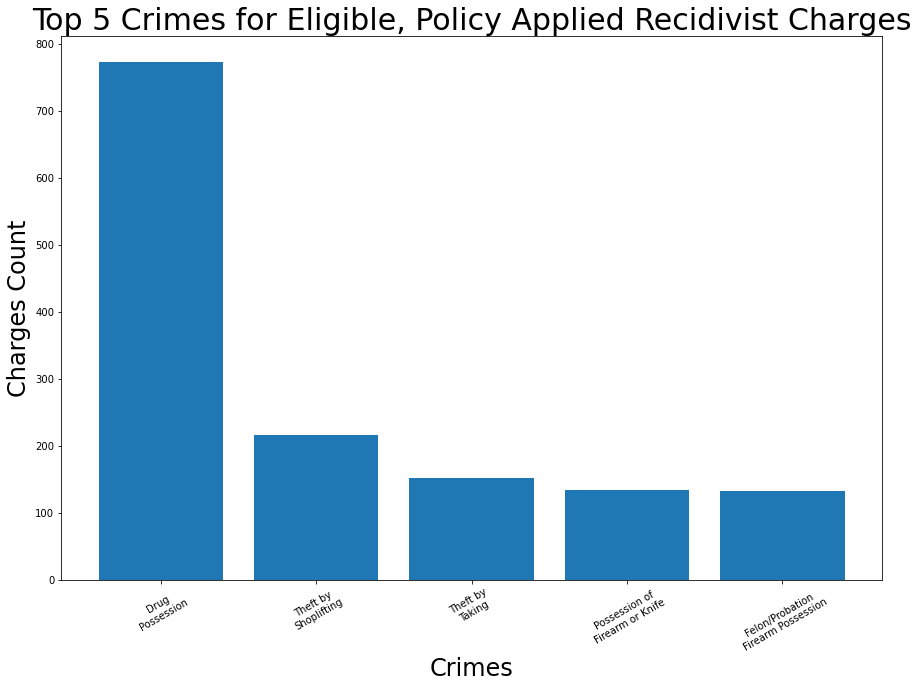

In [190]:
recidCount = eligibleByDiscretionApplied.cleanedStatute.value_counts().rename_axis('Statute').reset_index(name='Count')
labels = recidCount.Statute
counts = recidCount.Count

#names = list(labels)[:5]
names = ['Drug\nPossession', 'Theft by\nShoplifting', 'Theft by\nTaking', 'Possession of\nFirearm or Knife', 'Felon/Probation\nFirearm Possession']
values = list(counts)[:5]

pyplot.figure(figsize=(50, 10))
pyplot.subplot(131)
pyplot.bar(names, values)
pyplot.title('Top 5 Crimes for Eligible, Policy Applied Recidivist Charges', fontdict={'fontsize': 30})
pyplot.xlabel('Crimes', fontsize=24)
pyplot.ylabel('Charges Count', fontsize=24)
pyplot.matplotlib.rc('xtick', labelsize=24) 
pyplot.matplotlib.rc('ytick', labelsize=24)
pyplot.xticks(rotation=30)

pyplot.savefig('crimes_recid_applied.png', dpi=300, bbox_inches='tight')

pyplot.show()

Bar chart displaying the top 5 most frequent statutes for policy not applied recidivists' charges for subsequent arrests.

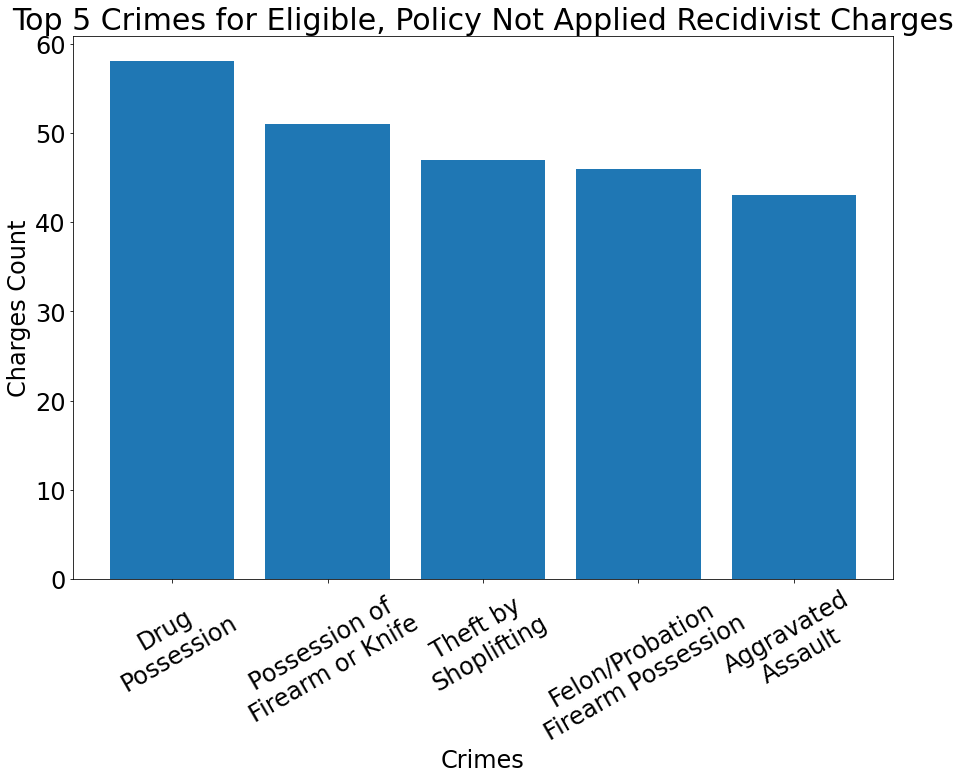

In [191]:
recidCount = notAppliedRecidivistsCharges.cleanedStatute.value_counts().rename_axis('Statute').reset_index(name='Count')
labels = recidCount.Statute
counts = recidCount.Count

#names = list(labels)[:5]
names = ['Drug\nPossession', 'Possession of\nFirearm or Knife', 'Theft by\nShoplifting', 'Felon/Probation\nFirearm Possession', 'Aggravated\nAssault']
values = list(counts)[:5]

#statutesToCheck = eligibleByDiscretionNotFlagged[eligibleByDiscretionNotFlagged['ArrestSincePolDisposition'] == True].cleanedStatute.value_counts().rename_axis('Statute').reset_index(name='Count')
#colors = ['yellowgreen' if (x in eligibleDis) else 'mediumorchid' for x in statutesToCheck.Statute]

pyplot.figure(figsize=(50, 10))
pyplot.subplot(131)
pyplot.bar(names, values)
pyplot.title('Top 5 Crimes for Eligible, Policy Not Applied Recidivist Charges', fontdict={'fontsize': 30})
pyplot.xlabel('Crimes', fontsize=24)
pyplot.ylabel('Charges Count', fontsize=24)
pyplot.matplotlib.rc('xtick', labelsize=24) 
pyplot.matplotlib.rc('ytick', labelsize=24)
pyplot.xticks(rotation=30)

colors = {'Policy ineligible statute':'mediumorchid', 'Policy eligible felony':'yellowgreen'}         
labels = list(colors.keys())
handles = [pyplot.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
#pyplot.legend(handles, labels, fontsize=24)
pyplot.savefig('crimes_recid_notapplied.png', dpi=300, bbox_inches='tight')

pyplot.show()

Pie chart displaying the charge severity for policy applied recidivists' charges on subsequent arrests.

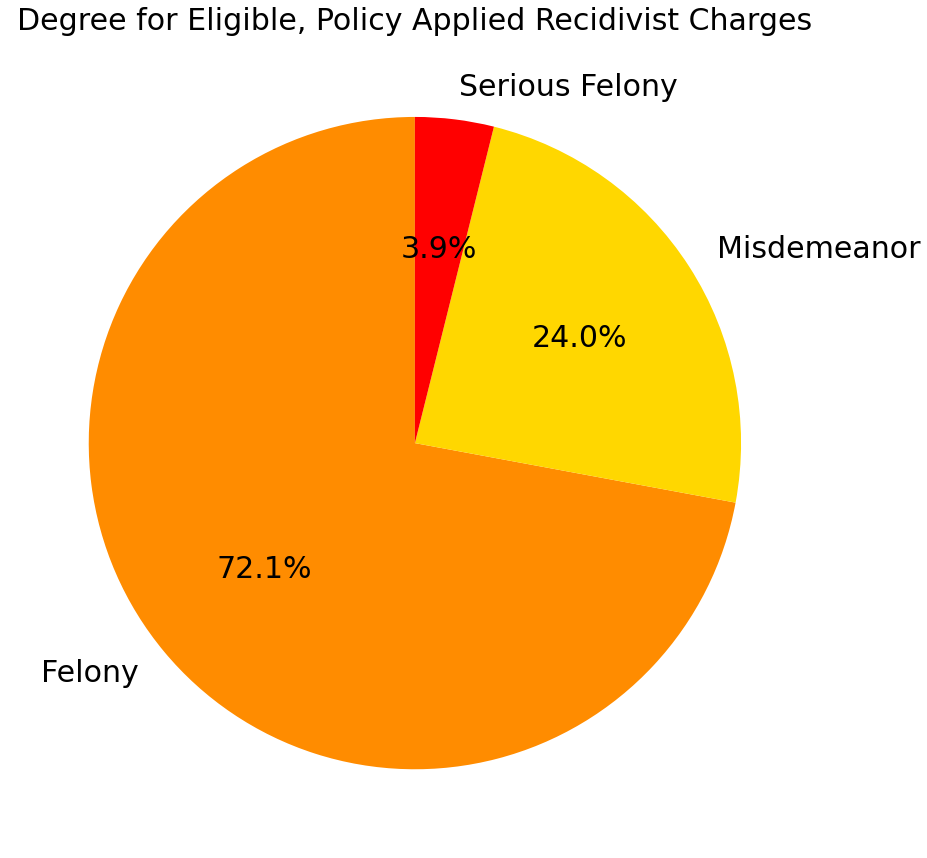

In [192]:
recidCount = appliedRecidivistsCharges.Degree.value_counts().rename_axis('Degree').reset_index(name='Count')
labels = recidCount.Degree
counts = recidCount.Count

sizes = counts/sum(counts)
colors = ['darkorange', 'gold', 'red'] 

fig, ax = pyplot.subplots(figsize = (15, 15))
pyplot.title('Degree for Eligible, Policy Applied Recidivist Charges', fontdict={'fontsize': 30})
ax.pie(sizes, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 30}, colors=colors, startangle= 90)
pyplot.savefig('pie_recid_degree.png')

Pie chart displaying the charge severity for policy not applied recidivists' charges on subsequent arrests.

<ipython-input-193-4f73bfc00bd1>:10: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  ax.pie(sizes, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 30}, colors=colors, startangle= 90)


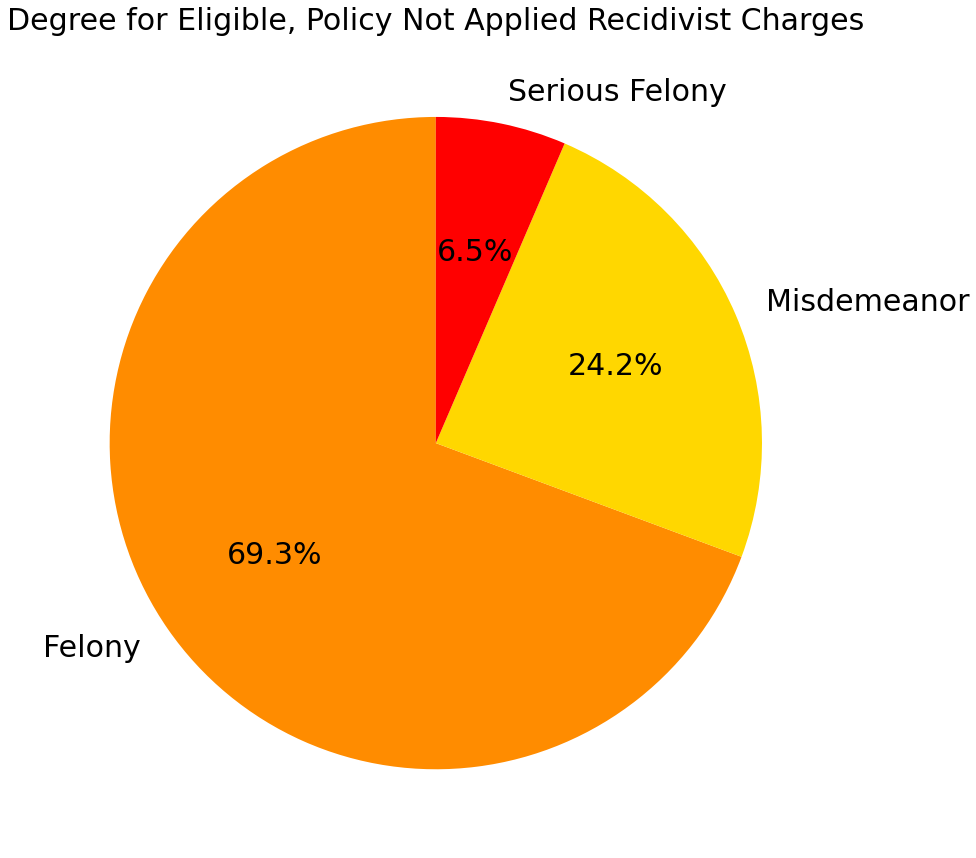

In [193]:
recidCount = notAppliedRecidivistsCharges.Degree.value_counts().rename_axis('Degree').reset_index(name='Count')
labels = recidCount.Degree
counts = recidCount.Count

sizes = counts/sum(counts)
colors = ['darkorange', 'gold', 'red'] 

fig, ax = pyplot.subplots(figsize = (15, 15))
pyplot.title('Degree for Eligible, Policy Not Applied Recidivist Charges', fontdict={'fontsize': 30})
ax.pie(sizes, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 30}, colors=colors, startangle= 90)
pyplot.savefig('pie_recid_degree_notapplied.png')

In [194]:
combined = result

Line graph displaying the number of policy eligible and policy applied charges per month

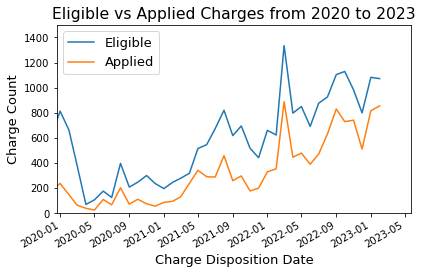

In [201]:
combined['FormattedDispositionDate'] = pd.to_datetime(combined['FormattedDispositionDate'])
combined['month_year'] = combined['FormattedDispositionDate'].dt.to_period('M')
combined['month_year'] = combined['month_year'].astype(str)
combined['month_year'] = pd.to_datetime(combined['month_year'])
combined_elig=combined[combined['CaseFlagDiscretion']==True]
combined_app=combined[combined['PolicyAppliedDiscretion']==True]
combined_app = combined_app.groupby(['month_year']).size().reset_index(name='counts')
combined_elig= combined_elig.groupby(['month_year']).size().reset_index(name='counts')
combined_app.set_index('month_year', inplace=True)
combined_elig.set_index('month_year', inplace=True)

combined_elig['counts'].plot(legend=True)
combined_app['counts'].plot(legend=True)

pyplot.rc('font', size=13)
pyplot.rc('xtick', labelsize=10)
pyplot.rc('ytick', labelsize=10)
pyplot.title('Eligible vs Applied Charges from 2020 to 2023')
pyplot.xlabel('Charge Disposition Date')
pyplot.ylabel('Charge Count')
pyplot.xlim([18250, 19500])
pyplot.ylim([0, 1500])
pyplot.legend(['Eligible','Applied'])
pyplot.tight_layout()
pyplot.savefig('applied_vs_elig.png', dpi=300, bbox_inches='tight',transparent=True)
pyplot.show()

Pie chart depicting the racial demographics for the defendants in the data set

In [196]:
combined_uniquePerson = combined.drop_duplicates(subset='UniquePersonID', keep='first', inplace=False, ignore_index=False)
combined_uniquePerson = combined_uniquePerson.dropna(subset=['UniquePersonID','Race']) #drop UniquePersonID and Race NaN

Group races into Black, white and other

In [197]:
combined_uniquePerson_grouped = combined_uniquePerson.replace({"M"}, {"Others"})
combined_uniquePerson_grouped = combined_uniquePerson_grouped.replace({"S"}, {"Others"})
combined_uniquePerson_grouped = combined_uniquePerson_grouped.replace({"U"}, {"Others"})
combined_uniquePerson_grouped = combined_uniquePerson_grouped.replace({"I"}, {"Others"})
combined_uniquePerson_grouped = combined_uniquePerson_grouped.replace({"H"}, {"Others"})
combined_uniquePerson_grouped = combined_uniquePerson_grouped.replace({"A"}, {"Others"})
combined_uniquePerson_grouped = combined_uniquePerson_grouped.replace({"R"}, {"Others"})
combined_uniquePerson_grouped = combined_uniquePerson_grouped.replace({"E"}, {"Others"})
combined_uniquePerson_grouped = combined_uniquePerson_grouped.replace({"O"}, {"Others"})
combined_uniquePerson_grouped = combined_uniquePerson_grouped.replace({"W"}, {"White"})
combined_uniquePerson_grouped = combined_uniquePerson_grouped.replace({"B"}, {"Black"})
combined_uniquePerson_grouped.Race.unique()

array(['White', 'Black', 'Others'], dtype=object)

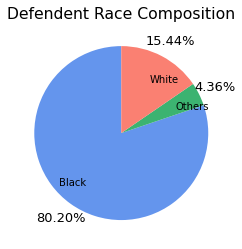

In [198]:
raceCountCombined = combined_uniquePerson_grouped.groupby('Race').count()
count = np.array(raceCountCombined)
mylabels = raceCountCombined.index.tolist()
colors = ['cornflowerblue', 'mediumseagreen', 'salmon']

pyplot.pie(raceCountCombined["level_0"], labels = mylabels,autopct='%0.2f%%',pctdistance=1.2,labeldistance=0.7, startangle = 90, colors = colors)
pyplot.title('Defendent Race Composition')
pyplot.savefig('Defendent Race.png',dpi=300, bbox_inches='tight', transparent=True)
pyplot.show() 

Pie chart depicting the racial demographics for DeKalb County, according to the United States Census Bureau

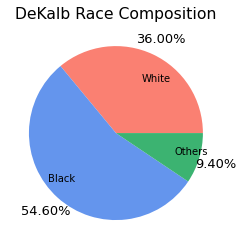

In [199]:
dekalb = [['White',36],['Black',54.6],['Others',9.4]]
dekalb_dem = pd.DataFrame(dekalb, columns=['Race','Percent'])
mylabels = dekalb_dem['Race'].tolist()
colors = ['salmon', 'cornflowerblue', 'mediumseagreen']

pyplot.pie(dekalb_dem['Percent'], labels = mylabels,autopct='%0.2f%%',pctdistance=1.2,labeldistance=0.7, colors=colors, startangle = 0)
pyplot.title('DeKalb Race Composition')
pyplot.savefig('DeKalb Race.png',dpi=300, bbox_inches='tight', transparent=True)
pyplot.show() 

Line chart depicting average days to disposition for each case for each charge in the data set for each disposition date from 2020-2023

In [ ]:
#format disposition dates and file dates to datetime objects
time = combined.dropna(subset=['FormattedDispositionDate','FormattedDateFiled'])
time['FormattedDispositionDate'] = pd.to_datetime(time['FormattedDispositionDate'])
time['disp_month_year'] = time['FormattedDispositionDate'].dt.to_period('M')
time['disp_month_year'] = time['disp_month_year'].astype(str)
time['disp_month_year'] = pd.to_datetime(time['disp_month_year'])
time['FormattedDateFiled'] = pd.to_datetime(time['FormattedDateFiled'])
time['file_month_year'] = time['FormattedDateFiled'].dt.to_period('M')
time['file_month_year'] = time['file_month_year'].astype(str)
time['file_month_year'] = pd.to_datetime(time['file_month_year'])
#find time elapsed in between (in days)
time['case_month_year'] = time['disp_month_year']-time['file_month_year']

#calculate average case_month_year per disposition date
time['case_month_year'] = [float(x) for x in time.case_month_year.dt.days]
time = time.groupby([time['FormattedDispositionDate'].dt.date])['case_month_year'].mean()
time = time.to_frame()

time["FormattedDispositionDate"] = time.index
time["year"]=pd.DatetimeIndex(time["FormattedDispositionDate"]).year
time["month"]=pd.DatetimeIndex(time["FormattedDispositionDate"]).month
time = time[time['year']>2016]
time["year_month"]=time["year"].astype(str)+"-"+time["month"].astype(str)
time = time.groupby(time['year_month'])['case_month_year'].mean() #issue here
time = time.to_frame()

time = time['case_month_year'].astype(str)
time = time.to_frame()
time = time[time['case_month_year'].str.contains("-") == False]
for i in range(0,len(time)):
  time['case_month_year'][i] = time['case_month_year'][i].split(" days",1)[0]

time['case_month_year'] = time['case_month_year'].astype(float).to_frame()

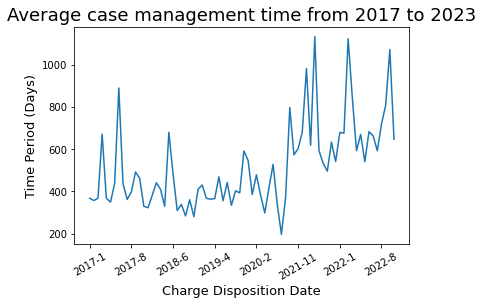

In [223]:
time['case_month_year'].plot()
pyplot.rc('font', size=15)
pyplot.rc('xtick', labelsize=12)
pyplot.rc('ytick', labelsize=12)
pyplot.title('Average case management time from 2017 to 2023')
pyplot.xlabel('Charge Disposition Date')
pyplot.xticks(rotation=30)
pyplot.ylabel('Time Period (Days)')
pyplot.savefig('Average case management time from 2017 to 2023.png', dpi=300, bbox_inches='tight',transparent=True)
pyplot.show()

In [224]:
result.to_csv('cleanedData.csv')
recidAvailable.to_csv('availableRecidivism.csv')